In [1]:
# Some ideas for using ML to analyze simulation outputs
#
# Alan Walker, September 2024
# (c) PassengerSim LLC
#
from collections import defaultdict
import os
import passengersim as pax
import time
import pandas as pd
import matplotlib.pyplot as plt
from passengersim.utils.tempdir import TemporaryDirectory
tempdir = TemporaryDirectory()

In [2]:
# Load data
scenario = os.getenv("paxsim_scenario", "U10")
if scenario == "3MKT":
    input_file = pax.demo_network("3mkt-aw")
    cfg = pax.Config.from_yaml(input_file)
elif scenario == "U10":
    network_file = pax.demo_network("/Users/alanw/projects/pxsim-clean/passengersim-core/networks/u10-network")
    rm_file = pax.demo_network("/Users/alanw/projects/pxsim-clean/passengersim-core/networks/rm-systems")
    places_file = pax.demo_network("/Users/alanw/projects/pxsim-clean/passengersim-core/networks/u10-places")
    control_file = pax.demo_network("/Users/alanw/projects/pxsim-clean/passengersim-core/networks/u10-aw")
    cfg = pax.Config.from_yaml([network_file, rm_file, places_file, control_file])
cfg.simulation_controls.random_seed = 42

FileNotFoundError: [Errno 2] No such file or directory: '/Users/alanw/projects/pxsim-clean/passengersim-core/networks/u10-network.yaml'

In [3]:
# Get the base case
cfg.simulation_controls.sys_k_factor = 0.1
cfg.simulation_controls.mkt_k_factor = 0.2
cfg.simulation_controls.simple_k_factor = 0.4
cfg.simulation_controls.pax_type_k_factor = 0.4

# These are set low for now, just to keep run times down while I'm playing
cfg.simulation_controls.num_trials = 1
cfg.simulation_controls.num_samples = 60
cfg.simulation_controls.burn_samples = 30

cfg.simulation_controls.tf_z_factor = 2.0

cfg.carriers['AL1'].truncation_rule = 1
cfg.carriers['AL2'].truncation_rule = 1
cfg.carriers['AL3'].truncation_rule = 1
cfg.carriers['AL4'].truncation_rule = 1

summary_eeee = pax.Simulation(cfg).run()

Output()

Task Completed after 43.83 seconds

In [6]:
cfg.carriers.AL1.rm_system = "rm_udp"
summary_ueee = pax.Simulation(cfg).run()

Output()

Task Completed after 259.01 seconds

In [7]:
#summary_ueee.cnx.close()
summary_ueee.carriers

,control,avg_rev,avg_sold,truncation_rule,avg_leg_lf,asm,rpm,ancillary_rev,avg_price,yield,sys_lf
carrier,,,,,,,,,,,
AL1,bp,3.049927e+06,9005.733333,1,74.477019,28588660.0,2.228217e+07,0.0,338.665077,0.136877,77.940586
AL2,leg,2.348643e+06,8400.133333,1,74.790826,23357790.0,1.974645e+07,0.0,279.595874,0.118940,84.539033
AL3,leg,9.952435e+05,5767.700000,1,79.289985,10003770.0,8.474606e+06,0.0,172.554655,0.117438,84.714119
AL4,leg,1.742670e+06,6055.066667,1,75.938562,16411000.0,1.372994e+07,0.0,287.803684,0.126925,83.663050


In [8]:
100.0 * (summary_ueee.carriers.avg_rev - summary_eeee.carriers.avg_rev) / summary_eeee.carriers.avg_rev

carrier
AL1    0.630100
AL2    1.529145
AL3   -0.146894
AL4    0.438752
Name: avg_rev, dtype: float64

In [13]:
# Get sold and sold_priceable 
import pandas as pd
import matplotlib.pyplot as plt
sql = """SELECT sample, SUM(sold) AS sold, SUM(sold_priceable) AS sold_priceable
         FROM path_class_detail d
         JOIN path_defs p USING(path_id)
         WHERE p.carrier = 'AL1' AND trial = 0 AND days_prior = 1 AND sample > 100
         GROUP BY sample ORDER BY sample"""
df_sold_ueee = pd.read_sql_query(sql, summary_ueee.cnx, index_col=["sample"])
summary_ueee.cnx.close()

/var/folders/1g/35_cq1b55hs6txctxdnm5nkr0000gn/T/ipykernel_49768/814343317.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sold_ueee = pd.read_sql_query(sql, summary_ueee.cnx, index_col=["sample"])


In [21]:
# What's the difference in revenue for each airline?
diff = summary_peee.carrier_history.revenue - summary_eeee.carrier_history.revenue
diff.AL4.mean()

np.float64(-5882.034359999998)

np.float64(0.6300995832056981)

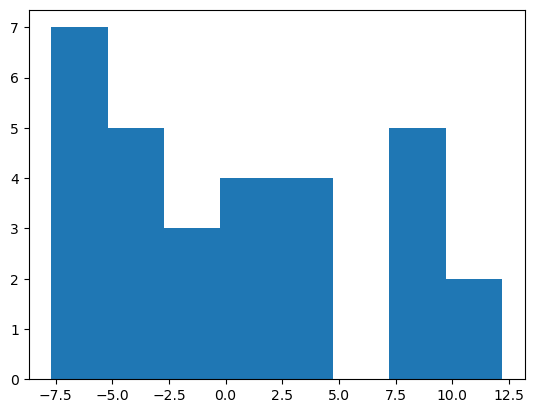

In [11]:
# Create a histogram of Percentage improvement for an airline
import matplotlib.pyplot as plt
tgt = "AL1"
avg_rev = summary_eeee.carrier_history2.revenue[tgt].mean()
pct = 100.0 * (summary_ueee.carrier_history2.revenue[tgt] - summary_eeee.carrier_history2.revenue[tgt]) / avg_rev
plt.hist(pct, bins=8)
plt.show
pct.mean()

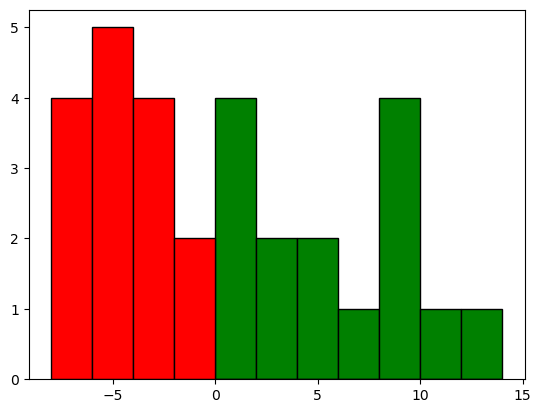

In [13]:
# Function to plot a histogram with the negatives in red and the positives in green
# Adapted from Maitreyee's code, still not quite as generic as I'd like but it's working for now
import numpy as np
from math import ceil, floor, log10

def get_bins(data, num_bins=20):
    """The goal is to have 'nice' sized bins with a boundary at zero.  This will almost always give
       a few more bins than requested, but it makes the graphs look good :-) """
    min_x = data.min()
    max_x = data.max()
    width = (max_x - min_x) / num_bins
    mults = [0.00001, 0.00002, 0.00005, 0.0001]
    while True:
        if mults[0] < width < mults[-1]:
            break
        mults = [m*10 for m in mults]
    
    # Now get the bin sizes
    if mults[0] < width < mults[1]:
        m = mults[0]
    elif mults[1] < width < mults[2]:
        m = mults[1]
    elif mults[2] < width < mults[3]:
        m = mults[2]

    min_x2 = m * floor(min_x / m)
    max_x2 = m * ceil(max_x / m)
    range2 = max_x2 - min_x2
    num_bins2 = int(range2 / m)

    bins = np.linspace(min_x2, max_x2, num_bins2+1)
    return bins


def win_loss_histogram(data, num_bins=5):
    min_x = data.min()
    max_x = data.max()
    width = (max_x - min_x) / num_bins
    custom_bins = get_bins(data, num_bins)
#    custom_bins = np.linspace(min_x, max_x, num_bins+1)
    pos_data, neg_data = data[data >= 0], data[data < 0]
    plt.hist(pos_data, bins=custom_bins, color='green', edgecolor='black')
    plt.hist(neg_data, bins=custom_bins, color='red', edgecolor='black')
    plt.show()

win_loss_histogram(pct)
    

In [15]:
# Get average leisure and business demand
# We only need to get it from one set of results, as we have the
# same random seed in each run
#
from collections import defaultdict
dmd_by_seg, dmd = defaultdict(float), defaultdict(float)
tot_business, tot_leisure = 0.0, 0.0
for idx, row in summary_ueee.demand_to_come.iterrows():
    k1 = (idx[1], idx[2], idx[3])  # trial, sample, segment
    k2 = (idx[1], idx[2])  # trial, sample
    d = float(row.iat[0])
    dmd_by_seg[k1] += d
    dmd[k2] += d
    if idx[3] == "business":
        tot_business += d
    else:
        tot_leisure += d
# dmd

avg_business, avg_leisure = tot_business / len(dmd), tot_leisure / len(dmd)
avg_business, avg_leisure

(11175.6, 20369.733333333334)

In [16]:
# Now compare stuff to get some features for ML
# Are business and leisure demands above or below average?
# These aren't truly observable in a real-world system, but forecasts might be a good proxy
# or priceable vs. yieldable bookings, etc.
raw_data = []
for key, val in dmd.items():
    key_b, key_l = (key[0], key[1], "business"), (key[0], key[1], "leisure")
    dmd_b, dmd_l = dmd_by_seg[key_b], dmd_by_seg[key_l]
    hi_b = 1 if dmd_b > avg_business else 0
    hi_l = 1 if dmd_l > avg_leisure else 0
    hi_both = 1 if hi_b and hi_l else 0
    hi_neither = 0 if hi_b or hi_l else 1
    # print (key, val, dmd_b, hi_b, dmd_l, hi_l, hi_both, hi_neither)
    raw_data.append([val, dmd_b, dmd_l, hi_b, hi_l, hi_both, hi_neither])
x_df = pd.DataFrame(raw_data, columns = ["tot_dmd", "dmd_b", "dmd_l", "hi_b", "hi_l", "hi_both", "hi_neither"])
x_df.head()


,tot_dmd,dmd_b,dmd_l,hi_b,hi_l,hi_both,hi_neither
0,29011.0,9840.0,19171.0,0,0,0,1
1,28045.0,10441.0,17604.0,0,0,0,1
2,32755.0,11403.0,21352.0,1,1,1,0
3,33010.0,11893.0,21117.0,1,1,1,0
4,26764.0,9711.0,17053.0,0,0,0,1


In [17]:
# Make it a classification problem
# This is a simple above / below zero.  We might try predicting highest or lowest quintile
# in a future iteration, or even try a continuous (regression) problem
pct2 = [1 if p > 0 else 0 for p in pct]
y_df = pd.DataFrame(pct2)
y_df.head()

,0
0,0
1,0
2,0
3,1
4,0


In [18]:
# Try XGBoost
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.25, random_state=42)
model = XGBClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 75.00%


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

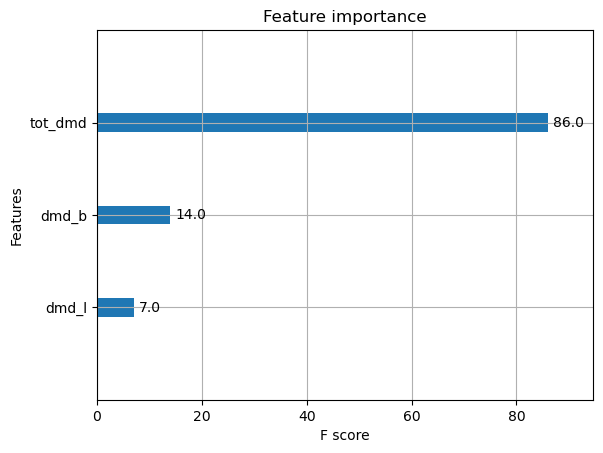

In [19]:
# What features did it use?
plot_importance(model)
#plot.show()

In [20]:
# Try logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression(random_state=16, solver="liblinear")
logreg.fit(x_train, y_train.values.ravel())
y_pred = logreg.predict(x_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.875


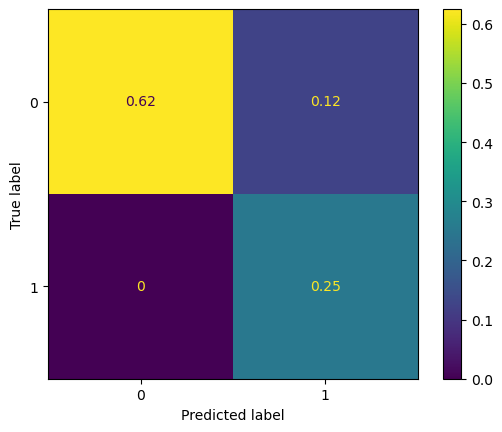

In [21]:
# Create a confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred, labels=logreg.classes_, normalize="all")
# cnf_matrix
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cnf_matrix,
                                      display_labels=logreg.classes_)
disp.plot()
plt.show()

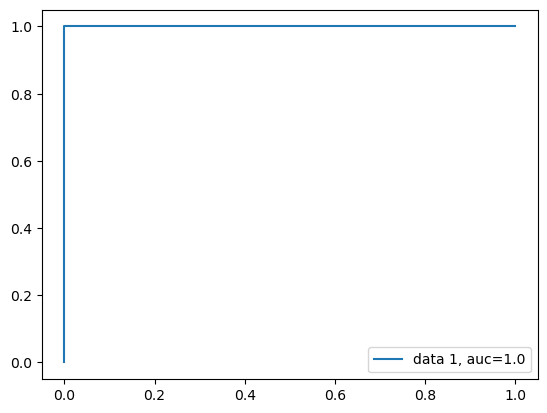

In [22]:
# Create a Receiver Operating Curve (ROC)
y_pred_proba = logreg.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()